<a href="https://colab.research.google.com/github/Ardeaa/Netology_HW/blob/master/unet_learner_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Импорт библиотек**

In [62]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai import *
import fastai
from fastai.callbacks.hooks import *

import matplotlib.pyplot as plt

## **Описание вспомогательных функций**

In [63]:
def display_image_mask_grid(n):
  images_list = []
  for i in range(n):
    images_list.append(random.choice(os.listdir(img_path)))
  for idx, image in enumerate(images_list):  
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    img = plt.imread(str(img_path/image))
    axs[0].imshow(img)
    msk = plt.imread(str(mask_path/image))
    axs[1].imshow(msk, cmap='gray')    
    plt.grid(False)
    plt.show() 

In [64]:
class MaskSegmentationLabelList(SegmentationLabelList):
    def open(self, fn): 
      return open_mask(fn, div=True)

class MaskSegmentationItemList(ImageList):
    _label_cls,_square_show_res = MaskSegmentationLabelList, False

In [65]:
def dice_loss(input, target):
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)

## **Указание пути и проверка исходных данных**

In [66]:
from fastai.vision import *
#src_path = Path('/content/AerialImageDataset/')
root_path = Path('/content/drive/My Drive/Netology/Datasets/InriaDataset/')

#image_hr_path = src_path/'train/images'
#mask_hr_path = src_path/'train/gt'
#test_hr_path = src_path/'test/images'

image_lr_path = root_path/'train'
test_lr_path = root_path/'test'
train_mask_lr_path = root_path/'masks'

#hr_images = ImageList.from_folder(image_hr_path)
#hr_masks = ImageList.from_folder(mask_hr_path)
#hr_tests = ImageList.from_folder(test_hr_path)

In [67]:
images = get_image_files(image_lr_path)
masks = get_image_files(train_mask_lr_path)
len(images),len(masks)

(180, 180)

In [68]:
root_dir = Path('/content/drive/My Drive/Netology/Datasets/InriaDataset')
train_path = root_dir/'train'
test_path = root_dir/'test'
mask_path = root_dir/'masks'
img_path = train_path
img_path, mask_path

(PosixPath('/content/drive/My Drive/Netology/Datasets/InriaDataset/train'),
 PosixPath('/content/drive/My Drive/Netology/Datasets/InriaDataset/masks'))

In [69]:
images = get_image_files(img_path)
masks = get_image_files(mask_path)
len(images),len(masks)

(180, 180)

In [70]:
# Check if all images are present in the folders 
images = get_image_files(img_path)
masks = get_image_files(mask_path)
len(images),len(masks)

(180, 180)

In [71]:
# Size of each image and its mask
image = open_image(images[0])
img_size = np.array(image.shape[1:])
print(image.shape)

mask = open_mask(masks[0], div=True)
print(mask.shape)
mask_size = np.array(mask.shape[1:])
print(mask.data)

np.unique(np.array(mask.data))

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


array([0, 1])

In [72]:
get_mask_file = lambda x: mask_path/f'{x.stem.split("/")[-1]}.tif'
img = images[0]
img, get_mask_file(img)

(PosixPath('/content/drive/My Drive/Netology/Datasets/InriaDataset/train/austin24.tif'),
 PosixPath('/content/drive/My Drive/Netology/Datasets/InriaDataset/masks/austin24.tif'))

## **Визуализация данных**

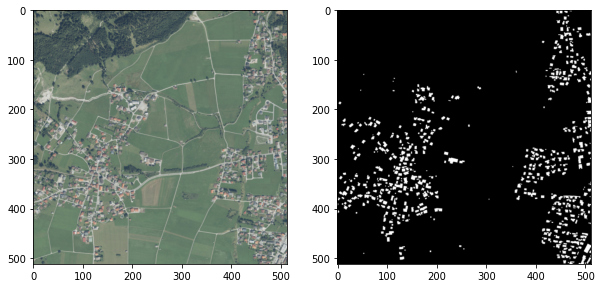

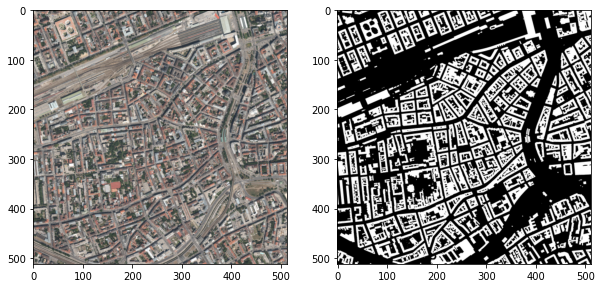

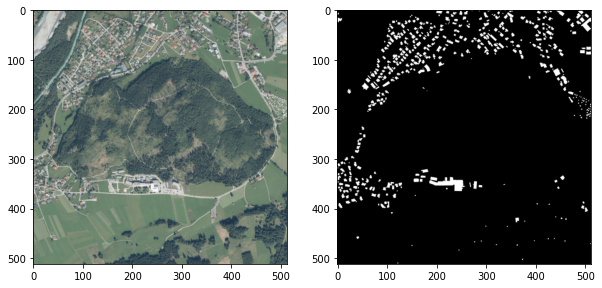

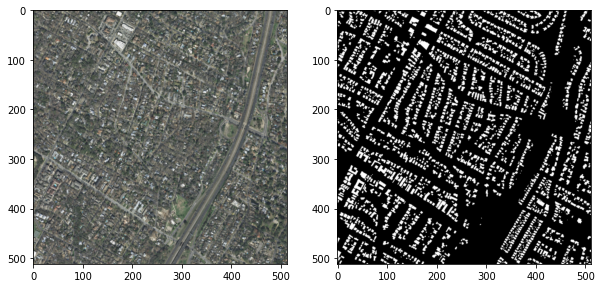

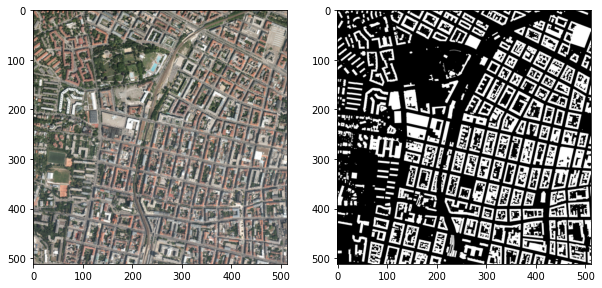

In [73]:
display_image_mask_grid(5)

### **Подготовка к обучению модели**

In [74]:
# Parameters
codes = np.array(['NotBuilding','Building'])
src_size = np.array(mask.shape[1:])
size = src_size
bs = 1

In [75]:
src = MaskSegmentationItemList.from_folder(train_path).split_by_fname_file(root_dir/'valid.txt').label_from_func(get_mask_file, classes=codes)
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
)

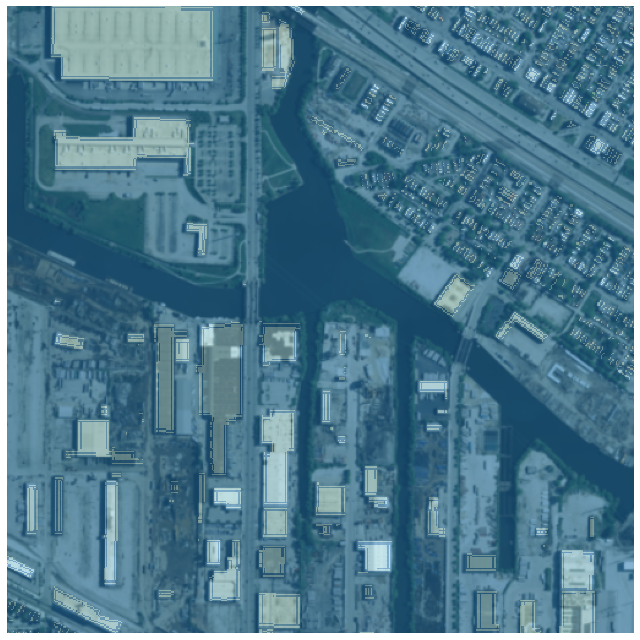

In [76]:
data.show_batch(rows=3, figsize=(12,9))

In [77]:
len(data.train_ds.x.items), len(data.train_ds.y.items),len(data.valid_ds.x.items), len(data.valid_ds.y.items)

(155, 155, 25, 25)

In [78]:
 # Labels
data.classes

array(['NotBuilding', 'Building'], dtype='<U11')

## **Описание метрики**

In [79]:
metrics = [accuracy_thresh, dice]
learn = unet_learner(data, models.vgg16_bn, metrics=metrics)
learn.metrics = metrics

## **Обучение модели**

In [80]:
lr = 1e-04
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,dice,time
0,0.274894,0.308119,0.492343,0.000000,07:19
1,0.265640,0.291529,0.499937,0.000000,07:27
2,0.260045,0.233043,0.499999,0.000000,07:16
3,0.242369,0.241963,0.500001,0.000171,07:24
4,0.238032,0.259726,0.499973,0.003058,07:13
5,0.243469,0.222662,0.499892,0.013459,07:23
6,0.216477,0.239741,0.499972,0.002215,07:12
7,0.225832,0.208874,0.499932,0.006850,07:24
8,0.215100,0.211493,0.499868,0.011072,07:14
9,0.205924,0.209723,0.499913,0.016390,07:23


In [81]:
learn.save("stage-1-rn34-512")

In [82]:
learn.fit_one_cycle(10, slice(lr))


epoch,train_loss,valid_loss,accuracy_thresh,dice,time
0,0.222344,0.217042,0.499925,0.008235,07:15
1,0.227949,0.204403,0.499861,0.009040,07:22
2,0.233097,0.215121,0.499949,0.017144,07:14
3,0.211239,0.232102,0.499967,0.074764,07:19
4,0.204813,0.212761,0.499777,0.019558,07:14
5,0.210247,0.192683,0.499809,0.028870,07:21
6,0.203004,0.241015,0.499719,0.050786,07:16
7,0.194869,0.192001,0.499679,0.038982,07:21
8,0.207823,0.214426,0.499650,0.039265,07:17
9,0.207883,0.186906,0.499649,0.042459,07:22


In [83]:
lr = 1e-04
learn.fit_one_cycle(10, slice(1e-6,lr))

epoch,train_loss,valid_loss,accuracy_thresh,dice,time
0,0.205926,0.191172,0.499699,0.037855,07:17
1,0.211345,0.234268,0.499692,0.069565,07:23
2,0.209124,0.211924,0.499740,0.013752,07:17
3,0.211847,0.200990,0.499711,0.041890,07:23
4,0.211634,0.188261,0.499455,0.045982,07:15
5,0.201871,0.195006,0.499793,0.056568,07:24
6,0.202827,0.216419,0.499877,0.033505,07:16
7,0.199679,0.255856,0.499783,0.060507,07:26
8,0.195676,0.256676,0.499543,0.058474,07:17
9,0.184556,0.212245,0.499700,0.047080,07:27


In [84]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,lr))

epoch,train_loss,valid_loss,accuracy_thresh,dice,time
0,0.215581,0.195908,0.499504,0.061111,07:16
1,0.199394,0.210781,0.499926,0.026822,07:27
2,0.199507,0.224055,0.500367,0.092112,07:16
3,0.184884,0.193423,0.499932,0.040536,07:25
4,0.198361,0.213134,0.499859,0.048915,07:14
5,0.207671,0.201657,0.499656,0.100012,07:25
6,0.191953,0.185061,0.499779,0.081354,07:17
7,0.187275,0.237972,0.499899,0.085448,07:25
8,0.193505,0.187248,0.499898,0.080770,07:17
9,0.185920,0.191292,0.499843,0.094318,07:25


In [85]:
learn.save("stage-2-rn34-512")

In [86]:
learn = learn.load("stage-2-rn34-512")

In [87]:
# Training the cycle for 20 epochs
learn.fit_one_cycle(20, max_lr=slice(1e-5,lr))

epoch,train_loss,valid_loss,accuracy_thresh,dice,time
0,0.181323,0.185679,0.499835,0.065143,07:18
1,0.198135,0.252533,0.499899,0.060140,07:26
2,0.190944,0.216333,0.499941,0.074214,07:18
3,0.185259,0.196669,0.499898,0.069789,07:25
4,0.197574,0.194164,0.499752,0.057976,07:23
5,0.184133,0.184892,0.499654,0.101352,07:30
6,0.194118,0.243663,0.499754,0.033879,07:22
7,0.189400,0.196644,0.499939,0.069493,07:29
8,0.195557,0.191155,0.500091,0.094403,07:23
9,0.200287,0.187320,0.499938,0.088591,07:29


In [88]:
learn.save("stage-2-rn34-512-2")

In [89]:
learn = learn.load("stage-2-rn34-512-2")

In [90]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)
outputs.shape

torch.Size([1, 2, 512, 512])

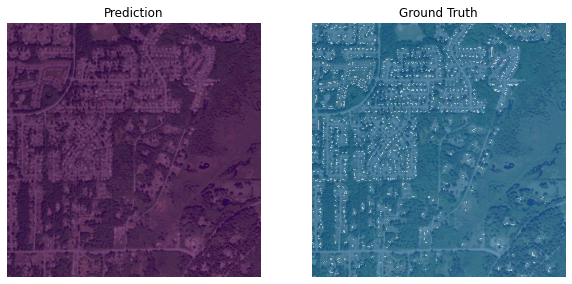

In [91]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1].sigmoid()>0.70)), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

## **Проверка на тестовых данных**

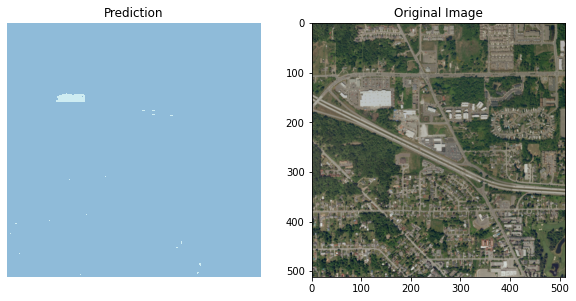

In [92]:
img = open_image(test_path/'bellingham20.tif')
prediction = learn.predict(img)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_title('Prediction')
prediction[0].show(figsize=(5,5), ax=ax1)
ax2.set_title('Original Image')
img = plt.imread(str(test_path/'bellingham20.tif'))
ax2.imshow(img)